# Linear uncertainty propagation

In this notebook, we provide an example of using Linear Uncertainty Propagation (LUP) to quickly gain an understanding of how small changes in low-dimensional input variables can affect the output.

In short, linear uncertainty propagation, whose implementation described by [[Giordano, 2016]](https://arxiv.org/abs/1610.08716) uses the multiple-dispatch features of the Julia language, can be described as the characterization of the second-order effects of a generic function $f(x)$ when subject to normal input variables.

For one dimensional variables, assuming that $x \sim \mathcal{N}(\mu_x, \sigma_x)$, for small $\sigma^2_x$ one can use the Taylor's expansion truncated at the second order to write
\begin{equation}
    f(x) \simeq f(\mu_x) + f'(\mu_x)(x - \mu_x),
\end{equation}
where $f'$ denotes the derivative of $f$. This makes it trivial to propagate gaussian quantities, since the mean value is found by computing $f(\mu_x)$ while the variance is simply $Var(f(x)) = |f'(\mu_x)|^2\sigma^2_x$.

If $f(x)$ is a function in `jax`, we can easily find the derivative at $\mu_x$ using the using forward automatic differentiation as implemented in `jax.jvp`, without having to store any intermediate value. This is done internally by the `luprox` package, which exposes the `linear_uncertainty` method that takes a jax-function as input and returns a new function that implements LUP on that function. The new function will take an extra argument, which is the covariance matrix of the inputs.

In [ ]:
# Download a CT image and install luprox and opencv
!wget -O ct.jpg https://upload.wikimedia.org/wikipedia/commons/7/77/CT_of_sclerotic_lesions_in_the_skull_in_renal_osteodystrophy.jpg
!pip install git+https://github.com/astanziola/luprox
!pip install opencv-python

In [17]:
# Import required packages
import numpy as np
from jax import numpy as jnp
from jax import random, nn, value_and_grad, jit, grad, vmap
from jax import lax
from jax.example_libraries import optimizers
from functools import partial
from tqdm import tqdm
from matplotlib import pyplot as plt
from luprox import linear_uncertainty, mc_uncertainty

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from jwave.geometry import Domain, Medium, TimeAxis, Sources, _circ_mask, _points_on_circle, Sensors
from jwave.signal_processing import gaussian_window, apply_ramp, smooth, analytic_signal
from jwave.acoustics import simulate_wave_propagation

The following code reads the CT image and transforms it into a speed of sound map

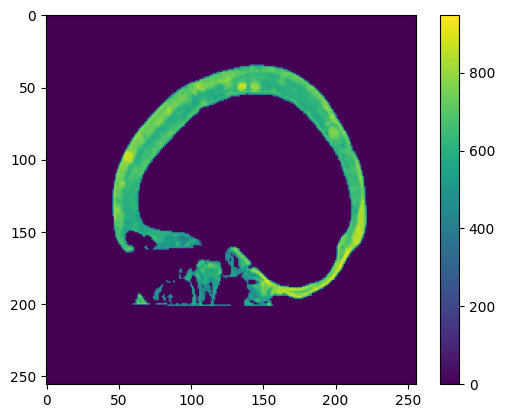

In [4]:
import cv2

# load image as gray scale and convert to numpy
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = np.asarray(cv2.resize(img, (192, 192)))/255.
    img[img<0.4] = 0.
    img = np.pad(img, ((10, 32+22), (38, 26)), 'constant', constant_values=(0, 0))
    return img*1000

img = read_img("./ct.jpg")
plt.imshow(img)
plt.colorbar()

In [5]:
from jwave import FourierSeries

In [6]:
# Settings
N = (256, 256)
dx = (.4e-3, .4e-3)
cfl = 0.2
num_sources = 16
source_freq = 0.3e6
source_mag = 1e-5
random_seed = random.PRNGKey(42)

# Define domain
domain = Domain(N, dx)

# Define medium
sound_speed = FourierSeries(img, domain)
medium =  Medium(domain=domain, sound_speed=sound_speed + 1480, pml_size=20.)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)

# Sources
source_mag = source_mag/time_axis.dt
t = time_axis.to_array()
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 5e-6, 2e-6)
x, y = _points_on_circle(num_sources,110,(128,128))
source_positions = (jnp.array(x), jnp.array(y))

src_signal = jnp.stack([signal]*num_sources)
sources = Sources(
    positions=source_positions,
    signals=jnp.stack([signal]),
    dt=time_axis.dt,
    domain=domain,)

To apply LUP to a j-Wave simulation, all we need to do is to start with a simulation function and wrap it on a new function that takes a single number as input. In this case, we are interested in the average power of the field over all timesteps.

In [8]:
# Run simulations
@jit
def simulate_sos(sound_speed):
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20.)
    return simulate_wave_propagation(medium, time_axis, sources=sources, checkpoint=True)

In [9]:
pressure = simulate_sos(sound_speed)

In [10]:
def get_field(bone_sos):
    sos = sound_speed*bone_sos + 1480
    p = simulate_sos(sos).on_grid
    p_max = jnp.mean(jnp.abs(p)**2, axis=0)
    return jnp.sqrt(p_max + 1e-6)

In [11]:
p = get_field(1.)

Text(0.5, 1.0, 'Average energy')

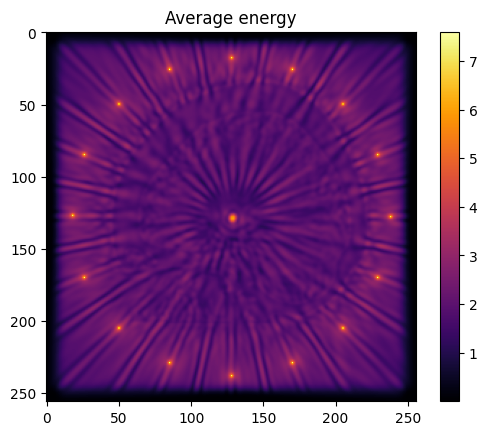

In [12]:
from jwave.utils import show_field
plt.imshow(p, cmap="inferno")
plt.colorbar()
plt.title("Average energy")

To obtain uncertainty,`get_field` function is fed to the `linear_uncertainty` decorator from the `luprox` package, which transforms it as described above.

In [13]:
get_field_lup = linear_uncertainty(get_field)

Add a 1% uncertainty in the bone sound speed

In [14]:
covariance = jnp.array([[(0.01)**2]])

And call the transformed function, to obtain the mean and covariance maps

In [15]:
x = jnp.array([1.])
mu_linear, cov_linear = get_field_lup(x, covariance)

Running also 100 Monte Carlo simulations for comparison

In [16]:
from jax import random

get_field_lup = mc_uncertainty(get_field, 100)
mu_mc, cov_mc = get_field_lup(x, jnp.sqrt(covariance), random.PRNGKey(0))

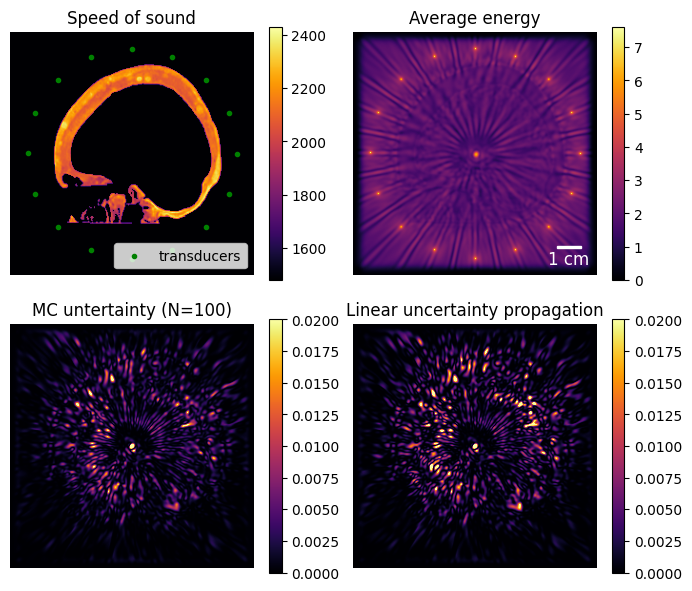

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(7,6), dpi=100)

im1 = ax[0,0].imshow(medium.sound_speed.on_grid, cmap="inferno", vmin=1480)
cbar = fig.colorbar(im1, ax=ax[0,0])
ax[0,0].scatter(
    source_positions[1],
    source_positions[0],
    c="g",
    marker=".",
    label="transducers",
)
ax[0,0].legend(loc="lower right")
ax[0,0].set_title("Speed of sound")
ax[0,0].set_axis_off()

im1 = ax[0,1].imshow(p, cmap="inferno", vmin=0)
cbar = fig.colorbar(im1, ax=ax[0,1])
ax[0,1].axis('off')
ax[0,1].set_title('Average energy')

# Scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(
    ax[0,1].transData,
    25, '1 cm', 'lower right', 
    pad=0.3,
    color='white',
    frameon=False,
    size_vertical=2,
    fontproperties=fontprops)
ax[0,1].add_artist(scalebar)

im1 = ax[1,0].imshow(cov_mc, cmap="inferno", vmin=0, vmax=0.02)
cbar = fig.colorbar(im1, ax=ax[1,0])
ax[1,0].axis('off')
ax[1,0].set_title('MC untertainty (N=100)')

im1 = ax[1,1].imshow(cov_linear, cmap="inferno", vmin=0, vmax=0.02)
cbar = fig.colorbar(im1, ax=ax[1,1])
ax[1,1].axis('off')
ax[1,1].set_title('Linear uncertainty propagation')

fig.tight_layout()